In [1]:
import torch
import torch.nn as nn
import src.model.AudioAligmentModel as AudioAligmentModel
model = AudioAligmentModel(
    input_dim = 144,
    num_classes = 129,
    num_blocks = 3,
    d_model = 256,
    nhead = 2,
    ffn_expansion_factor = 4,
    kernel_size = 31,
    dropout = 0.1,

)
model = nn.DataParallel(model)
model.load_state_dict(torch.load("outmodel_long50.pt"))
model.eval()

DataParallel(
  (module): AudioAligmentModel(
    (conv_layer): Conv1d(144, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (linear): Linear(in_features=256, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (positional_encoding): PositionalEncoding()
    (conformer): ModuleList(
      (0-2): 3 x ConformerBlock(
        (fnn1): FeedForwardModule(
          (fnn): Sequential(
            (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=256, out_features=1024, bias=True)
            (2): Swish()
            (3): Dropout(p=0.1, inplace=False)
            (4): Linear(in_features=1024, out_features=256, bias=True)
            (5): Dropout(p=0.1, inplace=False)
          )
        )
        (self_attention): MutliHead_SelfAttention(
          (attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
        )
        (conv): 

In [2]:
from src.datasets.audio_dataset import AudioDataset
from torch.utils.data import DataLoader
datasets = AudioDataset(
audio_dir = "dataset",
                        midi_dir = "dataset",
                        hop_size = 1024,
                        dataset_size = 1,
                        new_sr = 44100,
                        frame_size = 1
)
dataloader = DataLoader(
    datasets,          # Датасет
    batch_size=1,     # Размер батча
    num_workers=2     # Количество потоков для загрузки данных
)


/home/haser/Audio-alignment-model/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
import numpy as np
pred_tot = np.zeros((0, 128))
for batch_data in dataloader:
    audio = batch_data['audio']
    labels = batch_data['notes']
    y_pred = model(audio)
    pred_log = torch.squeeze(y_pred.to('cpu')).detach().numpy()
    pred_tot = np.append(pred_tot, pred_log[1, :, 1:], axis=0)
#predictions = pred_tot
predictions = np.exp(pred_tot)

In [36]:
print(predictions.shape)

(54120, 128)


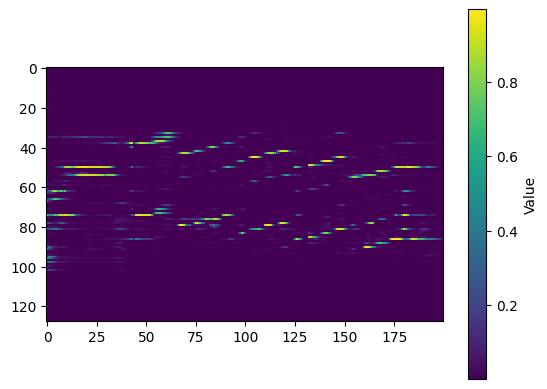

In [37]:
import matplotlib.pyplot as plt
plt.imshow(predictions.T[:,0:200], cmap='viridis', interpolation='nearest')
plt.colorbar(label='Value')
plt.show()

In [38]:
real_predictions = (predictions > 0.5).astype(int)

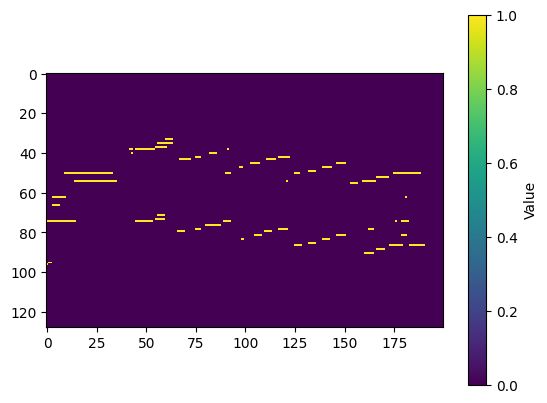

In [39]:
import matplotlib.pyplot as plt
plt.imshow(real_predictions.T[:,0:200], cmap='viridis', interpolation='nearest')
plt.colorbar(label='Value')
plt.show()

In [40]:
notes = []
for batch in dataloader:
    notes.append(batch['notes'][0])

In [41]:
print(notes[0].shape)

torch.Size([44, 128])


In [42]:
fn_annot_pitch = torch.vstack(notes[:100]).T

In [43]:
print(fn_annot_pitch.shape)

torch.Size([128, 4400])


In [44]:
predictions=predictions[:fn_annot_pitch.shape[1]]

In [45]:
fn_annot_pitch = fn_annot_pitch.numpy()

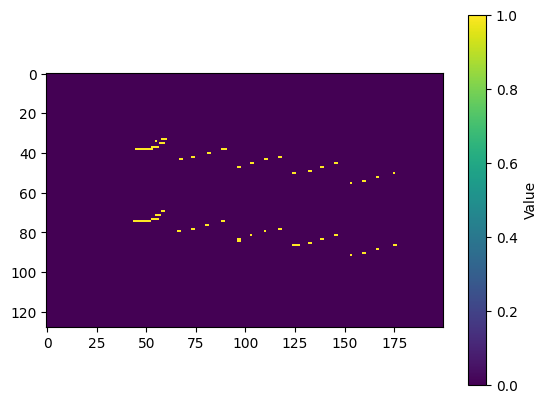

In [46]:
plt.imshow(fn_annot_pitch[:,0:200], cmap='viridis', interpolation='nearest')
plt.colorbar(label='Value')
plt.show()

In [47]:
# А кто ж знал что numpy не сохраняет порядок
#эта функция вообще не работает для тензоров из torch
def unique_rows_preserve_order(matrix):
    seen = set()
    unique_rows = []
    cnt = 0
    for row in matrix:
        row_tuple = tuple(row)
        if row_tuple not in seen:
            seen.add(row_tuple)
            unique_rows.append(row)
    unique_matrix = np.array(unique_rows)
    return unique_matrix

In [48]:
print(fn_annot_pitch.shape)

(128, 4400)


(405, 128)


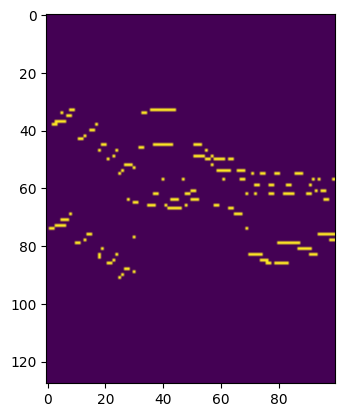

In [49]:
f_annot_pitch_unique = unique_rows_preserve_order(fn_annot_pitch.T)
print(f_annot_pitch_unique.shape)
plt.imshow(f_annot_pitch_unique.T[:,:100])

In [50]:
import pretty_midi
import pandas as pd
midi_data = pretty_midi.PrettyMIDI("dataset/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.midi")
data = {
    'start': [],
    'end': [],
    'pitch': []
}
for instrument in midi_data.instruments:
        for note in instrument.notes:
            data['start'].append(note.start)
            data['pitch'].append(note.pitch)
            data['end'].append(note.end)
            #data.append([note.pitch, note.start, note.end])
df = pd.DataFrame(data)
df.to_csv('temp.csv', sep=';', index=False)

In [51]:
df = pd.read_csv("temp.csv", sep=';', skiprows=1, header=None)
note_events = df.to_numpy()[:, :3]
print(note_events)
gt_segments = [[] for _ in range(128)]
for event in note_events:
    gt_segments[int(event[2])].append([event[0],event[1]])
print(gt_segments)

[[1.03255208e+00 1.22656250e+00 7.40000000e+01]
 [1.04427083e+00 1.24609375e+00 3.80000000e+01]
 [1.26953125e+00 1.30989583e+00 3.40000000e+01]
 ...
 [1.25455469e+03 1.25459635e+03 4.50000000e+01]
 [1.25455859e+03 1.25459766e+03 8.60000000e+01]
 [1.25465365e+03 1.25465495e+03 8.40000000e+01]]
[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [[948.4322916666666, 948.7421875], [1034.55859375, 1034.59375], [1034.91015625, 1034.94921875]], [[99.02604166666666, 99.14192708333331], [99.31510416666666, 99.37109375], [99.49609375, 99.57161458333331], [99.7109375, 99.75911458333331], [99.87890625, 99.953125], [100.10546875, 100.16536458333331], [100.26953125, 100.31770833333331], [100.46484375, 100.54427083333331], [100.57161458333331, 100.64583333333331], [100.76953125, 100.82552083333331], [100.92578125, 100.97786458333331], [101.10546875, 101.21744791666666], [101.21744791666666, 101.28515625], [101.3828125, 101.43229166666666],

In [ ]:
#Костыль т.к формулу тут я не знаю
segment_duration = datasets.get_duration(0) / len(predictions)
print(segment_duration)
print(predictions.shape)

0.2786363636363636
(4400, 128)


In [54]:
#Кажется что было бы очень мило обернуть всё это в один класс (если будешь переносить в прод займись)

def get_segments(A, segment_duration = segment_duration): #A.shape = (pitches, len(audio))
    predict_segments = []
    for i in range(A.shape[0]):
        found_segments = []
        L = 0
        len = 0
        for j in range(A.shape[1]):
            if A[i][j] == 1:
                if (len == 0):
                    L = j
                len+=1
            else:
                if (len > 0):
                    found_segments.append([L*segment_duration, (L+len)*segment_duration])
                L = j
                len = 0
        if (len > 0):
            found_segments.append([L*segment_duration, (L+len)*segment_duration])
        predict_segments.append(found_segments)
    return predict_segments 

def intersection_length(gt_segments, predict_segments):
    total_length = 0
    for gt_start, gt_end in gt_segments:
        for pred_start, pred_end in predict_segments:
            intersect_start = max(gt_start, pred_start)
            intersect_end = min(gt_end, pred_end)
            if intersect_start < intersect_end:
                total_length += intersect_end - intersect_start
    return total_length

def get_segments_length(segments):
    total_length = 0
    for segment in segments:
        total_length = total_length + max(0,segment[1] - segment[0])
    return total_length
def recall(A,gt_segments, segment_duration = segment_duration):
    predict_segments = get_segments(A,segment_duration)
    recall = 0
    for predict_segment, gt_segment in zip(predict_segments, gt_segments):
        if predict_segment == []:
            recall = recall + 1
        else:
            recall = recall + (intersection_length(predict_segment, gt_segment))/(get_segments_length(predict_segment))
    return recall/len(gt_segments)
def precision(A,gt_segments, segment_duration = segment_duration):
    predict_segments = get_segments(A,segment_duration)
    precision = 0
    for predict_segment, gt_segment in zip(predict_segments, gt_segments):
        if predict_segment == []:
            precision = precision + 1
        else:
            precision = precision + (intersection_length(predict_segment, gt_segment))/(get_segments_length(gt_segment))
    return precision/len(gt_segments)
def f1(A,gt_segments,segment_duration = segment_duration):
    P = precision(A,gt_segments,segment_duration)
    R = recall(A,gt_segments,segment_duration)
    return (2.0 * (P * R)/(P+R))

## Косинусное расстояние

(4400, 128)
(405, 128)
Find path
Accumulated cost matrix:
 [[1.00000000e+00 1.42677220e+00 2.01202197e+00 ... 3.70792046e+02
  3.71791267e+02 3.72788344e+02]
 [2.00000000e+00 1.57583072e+00 2.12575846e+00 ... 3.70892486e+02
  3.71791722e+02 3.72785830e+02]
 [3.00000000e+00 2.11451748e+00 2.24899083e+00 ... 3.70866137e+02
  3.71865694e+02 3.72786528e+02]
 ...
 [4.39800000e+03 4.18245401e+03 4.08100316e+03 ... 1.46439285e+03
  1.46433518e+03 1.46339393e+03]
 [4.39900000e+03 4.18343087e+03 4.08198658e+03 ... 1.46502609e+03
  1.46483963e+03 1.46355863e+03]
 [4.40000000e+03 4.18435763e+03 4.08293439e+03 ... 1.46564353e+03
  1.46537184e+03 1.46375410e+03]]
Optimal path: [(0, 0), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 2), (22, 2), (23, 2), (24, 2), (25, 2), (26, 2), (27, 2), (28, 2), (29, 2), (30, 2), (31, 2), (32, 2), (33, 2), (34, 2), (35, -1), (36, -1), (

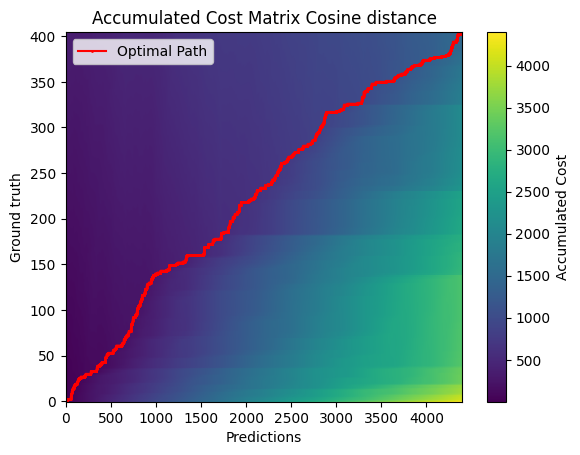

In [55]:
#Придумать обработку пауз
#По метрикам можно будет покрутить различные расстояния
#Ну и к тому же нужно придумать как чекать сходство accuracy или чё-то более интересное (типо сходства матриц)
from sklearn.metrics.pairwise import cosine_similarity
def cosine_distance(y, p):
    return cosine_similarity(y,p)
    #return np.sum(np.abs(y - p))

def dtw_multilabel_with_pauses(Y, P, distance_fn=cosine_distance):
    print(Y.shape)
    print(P.shape)
    N, M = len(Y), len(P)
    D = 1 - cosine_similarity(Y,P)
    
    # Build distance matrix
    #for i in range(N):
    #    for j in range(M):
    #        D[i, j] = distance_fn(Y[i], P[j])
    
    # Initialize accumulated cost matrix
    C = np.zeros((N, M))
    C[0, 0] = D[0, 0]
    
    # Fill first row and column
    for i in range(1, N):
        C[i, 0] = C[i-1, 0] + D[i, 0]
    for j in range(1, M):
        C[0, j] = C[0, j-1] + D[0, j]
    
    # Fill the rest of the matrix
    for i in range(1, N):
        for j in range(1, M):
            if np.all(Y[i] < 0.5):
                C[i,j] = D[i,j] + C[i-1,j]
            else:
                C[i, j] = D[i, j] + min(C[i-1, j], C[i, j-1], C[i-1, j-1])
    print("Find path")
    # Find the optimal path
    path = []
    i, j = N-1, M-1
    pause = False
    while i > 0 or j > 0:
        if not(pause):
            path.append((i, j))
        else:
            path.append((i,-1))
            pause = False
        if i == 0:
            j -= 1
        elif j == 0:
            if np.all(Y[i] < 0.5):
                pause = True
            i -= 1
        else:
            if np.all(Y[i] < 0.5):
                pause = True
                i -= 1
            else:
                min_cost = min(C[i-1, j], C[i, j-1], C[i-1, j-1])
                if min_cost == C[i-1, j]:
                    i -= 1
                elif min_cost == C[i, j-1]:
                    j -= 1
                else:
                    i -= 1
                    j -= 1
    if np.all(Y[0] < 0.5):
        path.append((0,-1))
    else:
        path.append((0, 0))
    path.reverse()
    
    return C, path

# Example usage
#Y = np.array([
#    [1, 0, 0],  # C active
#    [0, 0, 0],  # Pause
#    [0, 1, 0],  # E active
#    [0, 0, 1]   # G active
#])
a = [0] * 72
a[0] = 1
b = a
b[2] = 1
c = b
c[3] = 1
#Y = np.array([a,b,c])
P = np.array([
    b,  # C active
    c,  # E active (misaligned)
    a,   # G active
    c,
    b
])
C, path = dtw_multilabel_with_pauses(predictions, f_annot_pitch_unique)
print("Accumulated cost matrix:\n", C)
print("Optimal path:", path)

#visualization
#plt.figure(figsize=(8, 6))
plt.imshow(C.T, cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(label='Accumulated Cost')
plt.title('Accumulated Cost Matrix Cosine distance')
print(C.shape)
last = 0
new_path = []
for (i,j) in path:
    if (j == -1):
        j = last
    new_path.append((i,j))
    last = j
# Отметим оптимальный путь
path_x, path_y = zip(*new_path)
plt.plot(path_x, path_y, color='red', marker='o', markersize=1, label='Optimal Path')
plt.xlabel('Predictions')
plt.ylabel('Ground truth')
plt.legend()
plt.show()

In [56]:
#Построим нужную матрицу по пути
empty = [0 for _ in range(128)]
A = []
for step in path:
    if step[1] != -1:
        A.append(f_annot_pitch_unique[step[1]])
    else:
        A.append(empty)
A = np.array(A)
print(f"Recall: {recall(A.T,gt_segments)}")
print(f"Precision: {precision(A.T,gt_segments)}")
print(f"F1: {f1(A.T, gt_segments)}")

Recall: 0.5255968700460889
Precision: 0.5310246734555171
F1: 0.5282968305956028
